/tmp/ipykernel_462/3083444915.py:47: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa = QAOA(quantum_instance=Aer.get_backend('qasm_simulator'))


Solution found: fval=14.76881651159204, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_0=1.0, x_1_2=0.0, x_1_3=0.0, x_2_0=0.0, x_2_1=1.0, x_2_3=0.0, x_3_0=0.0, x_3_1=0.0, x_3_2=1.0, status=SUCCESS
Selected Route: [(0, 3), (1, 0), (2, 1), (3, 2)]


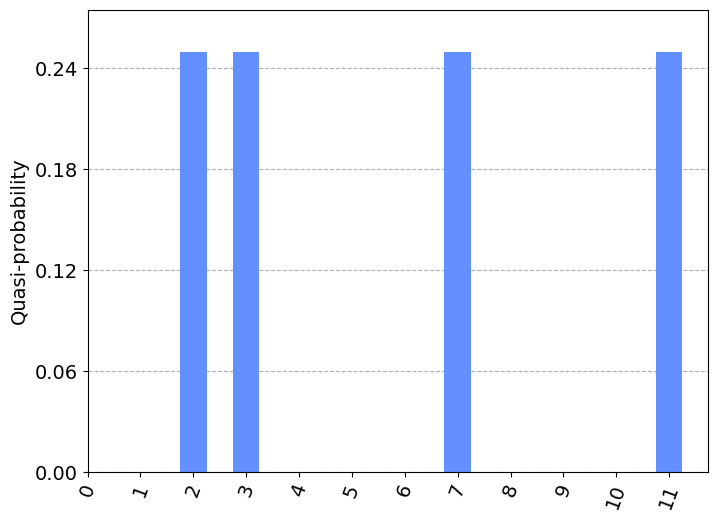

In [2]:
import numpy as np
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

# Define the coordinates of the cities
coordinates = np.array([[196.268975,1978.65365], [1111.551625,903.481175], [1726.041125,1175.81045], [1721.44055,615.3756595]])

# Calculate the distances between the cities (using Euclidean distance)
def calculate_distance(coord1, coord2):
    return ((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2) ** 0.5

num_cities = len(coordinates)
distance_matrix = np.zeros((num_cities, num_cities))

for i in range(num_cities):
    for j in range(num_cities):
        distance_matrix[i][j] = calculate_distance(coordinates[i], coordinates[j])

# Create a quadratic optimization problem for the TSP
problem = QuadraticProgram()
for i in range(num_cities):
    for j in range(num_cities):
        if i != j:
            problem.binary_var(f'x_{i}_{j}')

# Constraints: each city must be visited exactly once
for i in range(num_cities):
    constraint = {f'x_{i}_{j}': 1 for j in range(num_cities) if j != i}
    problem.linear_constraint(linear=constraint, sense='E', rhs=1, name=f'visit_once_{i}')

# Constraints: from each city, there should be exactly one transition
for j in range(num_cities):
    constraint = {f'x_{i}_{j}': 1 for i in range(num_cities) if i != j}
    problem.linear_constraint(linear=constraint, sense='E', rhs=1, name=f'leave_once_{j}')

# Objective function: minimize the total distance
linear_coeff = {f'x_{i}_{j}': distance_matrix[i][j] for i in range(num_cities) for j in range(num_cities) if i != j}
quadratic_coeff = {}
problem.minimize(linear=linear_coeff, quadratic=quadratic_coeff)

# Solve the problem using the QAOA algorithm
qaoa = QAOA(quantum_instance=Aer.get_backend('qasm_simulator'))
optimizer = MinimumEigenOptimizer(qaoa)

# Solve the problem
result = optimizer.solve(problem)
print('Solution found:', result)

# Map binary variable names to indices
var_to_indices = {(i, j): idx for idx, (i, j) in enumerate([(i, j) for i in range(num_cities) for j in range(num_cities) if i != j])}

# Extract the selected route from the binary variables
selected_route = []
for (i, j), idx in var_to_indices.items():
    if result.x[idx] == 1:
        selected_route.append((i, j))

# Print the selected route
print('Selected Route:', selected_route)

# Visualize the histogram of the solutions
plot_histogram(dict(enumerate(result.x)), figsize=(8, 6), bar_labels=False)
